Você trabalha como cientista de dados em uma empresa de meteorologia que coleta dados diários de temperatura ao longo dos anos. O objetivo da empresa é prever a temperatura de amanhã com base nas temperaturas anteriores, para fornecer uma previsão mais precisa. Para isso, você decide usar uma rede neural do tipo LSTM (Long Short-Term Memory), que é adequada para lidar com dados sequenciais.

Seu objetivo nesta oficina é construir um modelo de deep learning utilizando uma rede neural LSTM que possa prever a temperatura do dia seguinte com base nas temperaturas dos últimos 30 dias.

OBS.: O código até o passo 2 é fornecido pelo exercício.

## Passo 1: Preparação do Ambiente
Carregue as bibliotecas necessárias: Para começar, você vai usar bibliotecas como TensorFlow ou Keras, além do Pandas para manipulação de dados e Matplotlib para visualização.

In [201]:
# Importando as bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Passo 2: Carregamento e Preparação dos Dados
Para simplificar, você pode usar um conjunto de dados fictício ou dados históricos reais de temperaturas médias diárias. Vamos criar um conjunto de dados fictício de temperaturas para os últimos 100 dias.

In [202]:
# Gerando dados fictícios de temperaturas diárias para os últimos 100 dias
# A temperatura segue uma onda senoidal com um pouco de ruído para simular variação real

np.random.seed(0)

data = np.sin(np.linspace(0, 20, 100)) * 10 + 25 + np.random.normal(0, 1, 100)

# Transformando os dados em um DataFrame para facilitar a manipulação
df = pd.DataFrame(data, columns=['Temperatura'])

# Exibindo as primeiras 5 linhas do DataFrame para visualizar os dados
print(df.head())

   Temperatura
0    26.764052
1    27.406646
2    29.910104
3    32.937234
4    34.097184


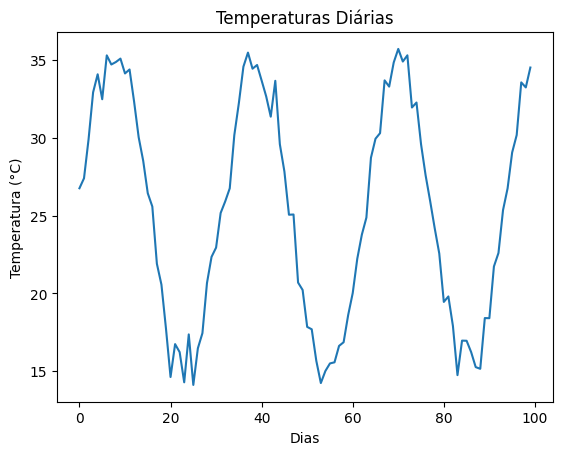

In [203]:
#visualizando os dados de temperatura para ter uma ideia das tendências

plt.plot(df)
plt.title('Temperaturas Diárias')
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.show()

## Passo 3: Pré-processamento dos Dados
**Agora, vamos preparar os dados para que possam ser usados em uma rede LSTM. Como LSTMs trabalham com sequências, vamos transformar nossos dados em janelas deslizantes, onde cada janela contém as temperaturas dos últimos 30 dias, e a rede deverá prever o 31o dia.**

In [204]:
#função para criação de janelas

def make_windows(series_1d, window_size=30, horizon=1):
  x, y = [], []
  for i in range(len(series_1d) - window_size - horizon + 1):
    x.append(series_1d[i : i + window_size])
    y.append(series_1d[i + window_size : i + window_size + horizon])
  x = np.array(x)
  y = np.array(y).reshape(-1, horizon)
  return x, y

#Série original em 2D para o scaler
values = df['Temperatura'].values.reshape(-1, 1)
window_size = 30
horizon = 1

#Número total de janelas possíveis
N = len(values) - window_size

#Proporções para split temporal nas janelas (70/15/15)
train_ratio, val_ratio = 0.70, 0.15
n_train = int(N * train_ratio)
n_val = int(N * val_ratio)
n_test = N - n_train - n_val

#final (índice) para janelas de treino que usam índices até window_size + n_train - 1
train_end_index_for_scaler = window_size + n_train

#O scaler ajustamente somente no treinamento para evitar vazamento
scaler = MinMaxScaler()
scaler.fit(values[:train_end_index_for_scaler])

#transformação da série inteira com o scaler
values_scaled = scaler.transform(values).flatten()

#gerando janelas
X_all, y_all = make_windows(values_scaled, window_size=window_size, horizon=horizon)

#split temporal nas janelas
X_train = X_all[:n_train]
y_train = y_all[:n_train]

X_val   = X_all[n_train : n_train + n_val]
y_val   = y_all[n_train : n_train + n_val]

X_test  = X_all[n_train + n_val :]
y_test  = y_all[n_train + n_val :]

#aguarda o shape (amostras, timesteps, features), nesse a feature é somente a temperatura
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print(f"Shapes -> X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

Shapes -> X_train: (49, 30, 1), X_val: (10, 30, 1), X_test: (11, 30, 1)


## Passo 4: Construção da Rede LSTM

**Agora você vai criar uma rede LSTM simples com uma camada LSTM e uma camada densa para prever a temperatura.**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

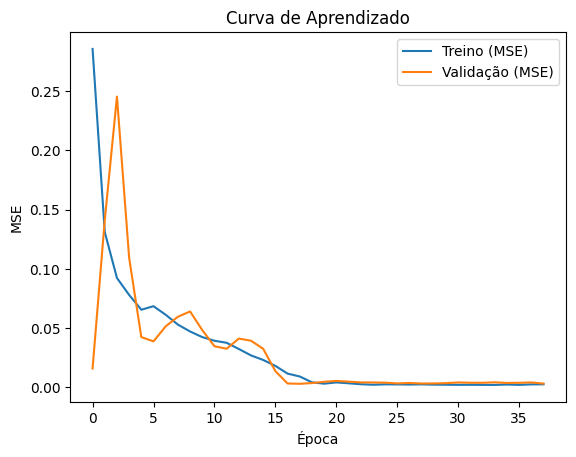

In [205]:
#modelo LSTM
model = Sequential([
    LSTM(64, input_shape=(window_size, 1), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # previsão do próximo dia
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

#early stopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0  # mude para 1 se quiser ver o progresso
)

#curva de aprendizado
plt.figure()
plt.plot(history.history['loss'], label='Treino (MSE)')
plt.plot(history.history['val_loss'], label='Validação (MSE)')
plt.title('Curva de Aprendizado')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.show()


Para esse projeto a rede LSTM se mostra mais eficeinte por sua capacidade de modelar dependências temporais e identificar padrões sequênciais, perfeita para aplicação com problemas de séries temporais como é o caso. A escolha de uma janela de 30 dias buscou fornecer ao modelo um histórico sufuciente para identificar tendências e variações sazonais, ao mesmo tempo em que estava de acordo como o volume limitado de dados gerados.

O Otimizador Adam foi escolhido pois pode combinar vantagens do método de gradiente adaptativo com momentum, proporcionando uma convergência mais estável e eficiente durante o treinanmento, especialmente em redes neurais profundas. A função de perda escolhida foi o Erro Quadrático Médio(MSE), adequado para problemas de regressão, pois penaliza erros maiores de forma mai severa, incentivando o modelo a reduzir desvios significativos entre os valores previstos e os valores reais

## Passo 5: Avaliação e Previsão
**Agora que o modelo está treinado, vamos avaliar o desempenho e fazer previsões nos dados de teste.**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
MAE (teste):  2.198 °C
RMSE (teste): 2.342 °C


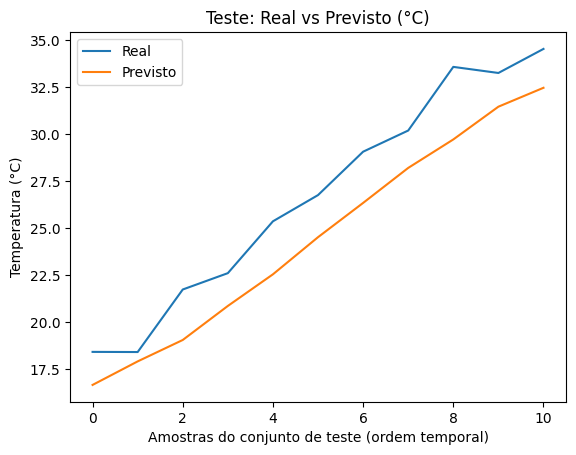

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Previsão para o próximo dia (°C): 33.19


In [206]:
#avaliação e previsões

#previsões no teste, espaço escalonado
y_pred_test_scaled = model.predict(X_test)

#convertendo y_test e y_pred de volta para °C
#shape 2D para inverse_transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred_test_scaled).flatten()

#Erro Médio Absoluto
mae = mean_absolute_error(y_test_inv, y_pred_inv)

#Erro Quadrático Médio Raiz(RMSE)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print(f"MAE (teste):  {mae:.3f} °C")
print(f"RMSE (teste): {rmse:.3f} °C")

#visualização dos reais vs preditos no teste
plt.figure()
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Previsto')
plt.title('Teste: Real vs Previsto (°C)')
plt.xlabel('Amostras do conjunto de teste (ordem temporal)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()

#prever o "dia seguinte" da última janela disponível
last_window = values_scaled[-window_size:]            # últimos 30 dias (escalados)
last_window = last_window.reshape(1, window_size, 1)  # shape para LSTM
next_scaled = model.predict(last_window)
next_temp = scaler.inverse_transform(next_scaled)[0, 0]

print(f"Previsão para o próximo dia (°C): {next_temp:.2f}")


Observou-se variação nos valores das métricas de validação entre diferentes execuções do modelo, mesmo sem alterações no código. Esse comportamento é esperado em redes neurais, uma vez que o processo de treinamento envolve inicialização aleatória dos pesos e métodos de otimização estocásticos, como o Adam. Além disso, o reduzido volume de dados contribui para amplificar essas variações, afetando a estabilidade dos resultados obtidos.

No pior cenário observado ss resultados obtidos para as métricas quantitativas no conjunto de teste, Erro Médio Absoluto (MAE) e Erro Quandrático Médio raiz (RMSE), sendo 9,24 C° e 10,63 C° respectivamente. Esses resultados evidenciam uma diferença significativa entre os valores previstos e os valores reais. Portanto o modelo não conseguiu capturar da melhor forma a tendência crescente da série temporal.

CONCLUSÃO

De forma geral, o modelo de rede neural foi implementado corretamente, seguindo um pipeline consistente para a previsão de séries temporais. No pior cenário observado, os resultados evidenciaram limitações significativas em sua capacidade de generalização, nas quais as previsões tendem a se concentrar em valores próximos à média da série, sem acompanhar a tendência de crescimento observada nos dados reais. A adoção de uma arquitetura mais sofisticada surge como uma possível melhoria para o comportamento do modelo. Ainda assim, o projeto cumpre seu objetivo didático ao demonstrar, de forma prática, a aplicação de redes LSTM, evidenciando a importância das decisões de pré-processamento e de modelagem para o desempenho final do modelo.